<a href="https://colab.research.google.com/github/harishk30/GNNcom/blob/main/COM_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.9 MB/s eta 0:00:00


In [2]:
import torch
from torch_geometric.data import Data

Creating/Loading Data

In [3]:
import random
def create_points(cube_length):
  points = []
  mass = []
  for i in range (0, 100):
    x = random.randrange(0, cube_length)
    y = random.randrange(0, cube_length)
    z = random.randrange(0, cube_length)
    m = random.randrange(0, 100)
    points.append([x, y, z])
    mass.append(m)
  com = []
  numerator_x = 0
  numerator_y = 0
  numerator_z = 0
  den = 0
  for i in range(len(points)):
    numerator_x += mass[i] * points[i][0]
    numerator_y += mass[i] * points[i][1]
    numerator_z += mass[i] * points[i][2]
    den += mass[i]
  com = [numerator_x/den, numerator_y/den, numerator_z/den]
  return [points, com, mass]

In [4]:
points = create_points(100)

In [5]:
import math
def distance(point1, point2):
  return math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2 + (point2[2] - point1[2])**2)

In [6]:
def create_edges(points, dist):
  edges = []
  edge_value = []
  for i in range(0, len(points[0])):
    for j in range(0, len(points[0])):
      if(j != i):
        two_dist = distance(points[0][j], points[0][i])
        if(two_dist <= dist):
          edges.append([i, j])
          edge_value.append(two_dist)
  return [edges, edge_value]

In [7]:
edges = create_edges(points, 50/3)
edge = edges[0]
edge_value = edges[1]

In [8]:
point_values = points[0]
center_of_mass = points[1]

In [9]:
for i in range(len(points[0])):
  point_values[i].append(points[2][i])

In [10]:
def create_graph(cube_len, i):
  points = create_points(cube_len)
  edges = create_edges(points, cube_len/i)
  edge = edges[0]
  edge_value = edges[1]
  point_values = points[0]
  center_of_mass = points[1]
  for i in range(len(points[0])):
    point_values[i].append(points[2][i])
  edge_index = torch.tensor(edge, dtype=torch.long)
  point_values = torch.tensor(point_values, dtype=torch.float)
  edge_value = torch.tensor(edge_value, dtype=torch.float)
  center_of_mass = torch.tensor(center_of_mass, dtype=torch.float)
  return [point_values, edge_index.t().contiguous(), edge_value, center_of_mass]

In [11]:
from torch_geometric.transforms import RandomNodeSplit
import torch_geometric.transforms as T
import torch.nn.functional as F
def turn_data(graph):
  graph_data = Data(x = graph[0], edge_index = graph[1], edge_attr = graph[2], y = graph[3])
  transform = T.NormalizeFeatures()
  graph_data = transform(graph_data)
  return graph_data

In [12]:
def create_training(x, i, cube_len):
  data_list=[]
  for j in range(x):
    data_list.append(turn_data(create_graph(cube_len, i)))
  return data_list

In [13]:
from torch_geometric.loader import DataLoader
data_list = create_training(1000, 3, 100)

In [14]:
graph = data_list[1]

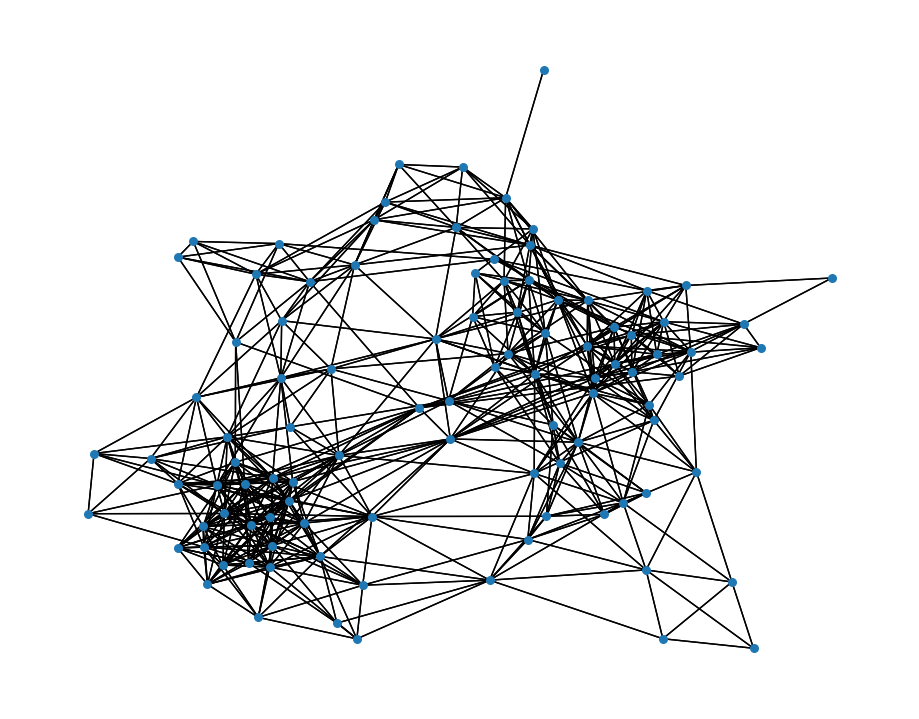

In [15]:
#EXTERNAL CODE
import random
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

def convert_to_networkx(graph, n_sample=None):

    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):

    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False)
    plt.show()


g, y = convert_to_networkx(graph)
plot_graph(g, y)

In [16]:
train_dataset = data_list[:700]
test_dataset = data_list[700:]

In [17]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Graph Neural Network

In [18]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool
# Pytorch Geometric tutorial & https://medium.com/stanford-cs224w/incorporating-edge-features-into-graph-neural-networks-for-country-gdp-predictions-1d4dea68337d

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        self.convs = [GATConv(data_list[0].num_node_features, hidden_channels, edge_dim = data_list[0].num_edge_features),
                      GATConv(hidden_channels, hidden_channels, edge_dim = data_list[0].num_edge_features),
                      GATConv(hidden_channels, hidden_channels, edge_dim = data_list[0].num_edge_features)]
        self.lin = Linear(hidden_channels, torch.unique(data_list[0].y).numel())

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch
        edge_attr = data.edge_attr

        # 1. Convolutions
        for conv in self.convs[:-1]:
          x = conv(x, edge_index, edge_attr = edge_attr)
          x = x.relu()
          x = F.dropout(x, p=0.5, training=self.training)
        x = self.convs[-1](x, edge_index, edge_attr=edge_attr)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Classification
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

model = GAT(hidden_channels=64)
print(model)

GAT(
  (lin): Linear(in_features=64, out_features=3, bias=True)
)


In [19]:
from IPython.display import Javascript
import torch.nn as nn
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GAT(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    model.train()
    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data)  # Perform a single forward pass.
         out = torch.flatten(out)
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()
     tot = 0
     num = 0
     for data in loader:
      out = model(data)
      pred = torch.flatten(out)
      L = nn.MSELoss()
      tot += L(pred, data.y)
      num += 1
     return tot/num  # Derive ratio of correct predictions.


for epoch in range(1, 20):
    train()
    train_loss = test(train_loader)
    test_loss = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Loss: 2166.2256, Test Loss: 2162.9209
Epoch: 002, Train Loss: 1901.9098, Test Loss: 1899.3623
Epoch: 003, Train Loss: 1655.0922, Test Loss: 1653.0521
Epoch: 004, Train Loss: 1425.3400, Test Loss: 1423.7473
Epoch: 005, Train Loss: 1213.3917, Test Loss: 1212.3555
Epoch: 006, Train Loss: 1018.3144, Test Loss: 1017.4813
Epoch: 007, Train Loss: 840.1555, Test Loss: 839.6242
Epoch: 008, Train Loss: 679.3880, Test Loss: 679.0577
Epoch: 009, Train Loss: 536.0708, Test Loss: 536.0865
Epoch: 010, Train Loss: 410.4655, Test Loss: 410.5518
Epoch: 011, Train Loss: 301.9560, Test Loss: 302.2534
Epoch: 012, Train Loss: 210.7057, Test Loss: 210.9015
Epoch: 013, Train Loss: 136.2082, Test Loss: 136.5020
Epoch: 014, Train Loss: 79.3079, Test Loss: 79.4463
Epoch: 015, Train Loss: 39.6545, Test Loss: 39.7032
Epoch: 016, Train Loss: 17.4449, Test Loss: 17.3050
Epoch: 017, Train Loss: 12.4850, Test Loss: 12.1260
Epoch: 018, Train Loss: 24.8976, Test Loss: 24.2269
Epoch: 019, Train Loss: 54

In [20]:
def turn_data_no_normalization(graph):
  graph_data = Data(x = graph[0], edge_index = graph[1], edge_attr = graph[2], y = graph[3])
  transform = T.NormalizeFeatures()
  graph_data = transform(graph_data)
  return graph_data

Evaluate

In [21]:
def evaluate_model(cube_len, i):
  data = create_training(50, cube_len, i)
  distances = []
  test_pt = []
  pred_pt = []
  for i in range(len(data)):
    test = turn_data(create_graph(100, 3))
    pred = model(test)
    test = test.y.detach().numpy()
    pred = pred.detach().numpy()
    test_pt.append(test)
    pred_pt.append(pred[0])
    distances.append(distance(test.tolist(), pred[0].tolist()))
  return [distances, test_pt, pred_pt]

In [22]:
evaluated = evaluate_model(100, 3)

In [23]:
avg_distance = sum(evaluated[0])/len(evaluated[0])
print(avg_distance)

11.822991140137493
